# Using physics informed neural networks (PINNs) to solve parabolic PDEs

## Introduction

We describe the PINN approach for approximating the solution $u:[0,T] \times \mathcal{D} \to \mathbb{R}$ of an evolution equation

$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$

where $\mathcal{N}$ is a nonlinear differential operator acting on $u$, 
$\mathcal{D} \subset \mathbb{R}^d$ a bounded domain,
$T$ denotes the final time and
$u_0: \mathcal{D} \to \mathbb{R}$ the prescribed initial data.
Although the methodology allows for different types of boundary conditions, we restrict our discussion to the inhomogeneous Dirichlet case and prescribe

$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$

where $\partial \mathcal{D}$ denotes the boundary of the domain $\mathcal{D}$ and $u_b: (0,T] \times \partial \mathcal{D} \to \mathbb{R}$ the given boundary data.

## Methodology

The method constructs a neural network approximation

$$
u_\theta(t,x) \approx u(t,x)
$$

of the solution of nonlinear PDE, where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The continuous time approach for the parabolic PDE as described in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) is based on the (strong) residual of a given neural network approximation $u_\theta \colon [0,T] \times \mathcal{D} \to \mathbb{R} $ of the solution $u$, i.e.,

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_t u_\theta$ and $\mathcal{N}[u_\theta]$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $u_\theta(t,x)$, but respects the underlying "physics" of the nonlinear PDE.
Both types of derivatives can be easily determined through automatic differentiation with current state-of-the-art machine learning libraries, e.g., TensorFlow or PyTorch.

The PINN approach for the solution of the initial and boundary value problem now proceeds by minimization of the loss functional

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

where $X$ denotes the collection of training data and the loss function $\phi_\theta$ contains the following terms:

  - the mean squared residual
$$
  \begin{align*}
   \phi_\theta^r(X^r) := \frac{1}{N_r}\sum_{i=1}^{N_r} \left|r_\theta\left(t_i^r, x_i^r\right)\right|^2
\end{align*}
$$
in a number of collocation points $X^r:=\{(t_i^r, x_i^r)\}_{i=1}^{N_r} \subset (0,T] \times \mathcal{D}$, where $r_\theta$ is the physics-informed neural network,
  - the mean squared misfit with respect to the initial and boundary conditions
$$
    \begin{align*}
   \phi_\theta^0(X^0) 
   := 
   \frac{1}{N_0}
   \sum_{i=1}^{N_0} \left|u_\theta\left(t_i^0, x_i^0\right) - u_0\left(x_i^0\right)\right|^2
   \quad \text{ and } \quad
   \phi_\theta^b(X^b) 
   := 
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|u_\theta\left(t_i^b, x_i^b\right) - u_b\left(t_i^b, x_i^b\right)\right|^2
    \end{align*}
$$
in a number of points $X^0:=\{(t^0_i,x^0_i)\}_{i=1}^{N_0} \subset \{0\} \times \mathcal{D}$ and $X^b:=\{(t^b_i,x^b_i)\}_{i=1}^{N_b} \subset (0,T] \times \partial \mathcal{D}$, where $u_\theta$ is the neural network approximation of the solution $u\colon[0,T] \times \mathcal{D} \to \mathbb{R}$.

Note that the training data $X$ consists entirely of time-space coordinates.

## Example: Burgers equation

To illustrate the PINN approach we consider the one-dimensional Burgers equation on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

This PDE arises in various disciplines such as traffic flow, fluid mechanics and gas dynamics, and can be derived from the Navier-Stokes equations, see 
([Basdevant et al., 1986](https://www.researchgate.net/publication/222935980_Spectral_and_finite_difference_solutions_of_Burgers_equation)).

In [13]:
import tensorflow as tf
import numpy as np

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

# Set Constants

pi = tf.constant(np.pi, dtype = DTYPE)
viscosity = 0.01/pi

# Define I.C.
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define B.C.
def fun_u_b(x, t):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype = DTYPE)

# Define Residual of the PDE
def fun_r(x, u, t, u_t, u_x, u_xx):
    return u_t - u*u_x - viscosity*u_xx

### 2. Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
Our numerical experiments indicate that this strategy slightly improves the observed convergence rate, but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [14]:
# Set number of data points
N_0 = 200
N_b = 200

N_r = 10000

# Set Boundary
tmin = 0
tmax = 1
xmin = -1
xmax = 1


# Lower Bound
lb = tf.constant([xmin, tmin], dtype = DTYPE)

# Upper Bound
ub = tf.constant([xmax, tmax], dtype = DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0, 1), dtype = DTYPE) * lb[1]
x_0 = tf.random.uniform((N_0, 1), lb[0], ub[0], dtype = DTYPE)
X_0 = tf.concat([x_0, t_0], axis = 1)


# Evaluate initial condition at x_0 ==> applying np.sin(pi*x) for every point at t = 0
u_0 = fun_u_0(x_0)

# Boundary data 
t_b = tf.random.uniform((N_b, 1), lb[1], ub[1], dtype = DTYPE)
x_b = lb[0] + (ub[0] - lb[0]) * tf.keras.backend.random_bernoulli((N_b, 1), 0.5, dtype = DTYPE)
X_b = tf.concat([t_b, x_b], axis = 1)

# Evaluate Boundary condition at (t_b, x_b)
u_b = fun_u_b(x_b, t_b)  #boundary = 0

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = DTYPE)
x_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = DTYPE)
X_r = tf.concat([x_r, t_r], axis = 1)

# Collect boundary and initial data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]




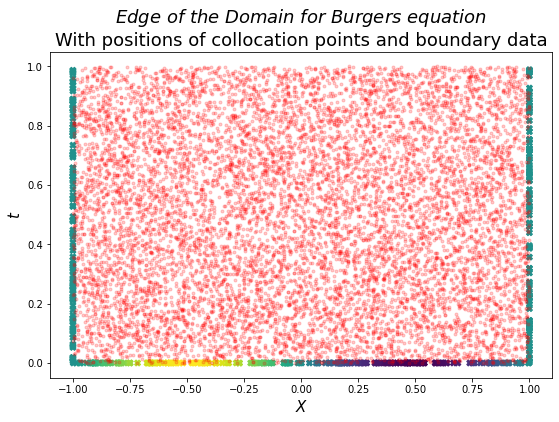

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (9, 6))
plt.scatter(x_0, t_0, c = u_0, marker = 'X', vmin = -1, vmax = 1)
plt.scatter(x_b, t_b, c = u_b, marker = 'X', vmin = -1, vmax = 1)
plt.scatter(x_r, t_r, c = 'r', marker = '.', alpha = 0.2)

plt.xlabel('$X$', fontsize = 15)
plt.ylabel('$t$', fontsize = 15)
plt.title('$Edge$ $of$ $the$ $Domain$ $for$ $Burgers$ $equation$\n\
With positions of collocation points and boundary data', fontsize = 18)
plt.show()


### 3. Set up network architecture

structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [16]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

        

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Burgers equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [17]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, t = X_r[:, 0:1], X_r[:,1:2]     #for [:, 0] is the row vector , while using [:, 0:1] will become column vector

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(x)
        tape.watch(t)

        # Determine residual 
        u = model(tf.stack([x[:,0], t[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape
    
    return fun_r(x, u, t, u_t, u_x, u_xx)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [18]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [19]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### 5. Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [20]:
# Initialize model aka u_theta

model = init_model()
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 3000], [1e-2, 1e-3, 5e-4])

# Choose the optimizers
optim = tf.keras.optimizers.Adam(learning_rate = lr)

Train the model for $N=5000$ epochs (takes approximately 3 minutes).
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [21]:
from time import time

# Define one training step as a Tensorflow function to increase speed of training 
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start time 
t0 = time()
for i in range(N+1):
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if  i%50 ==0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))
        

print('\nComputation time : {} seconds'.format(time()- t0))

It 00000: loss = 7.57410049e-01
It 00050: loss = 1.53279066e-01
It 00100: loss = 9.36233327e-02
It 00150: loss = 8.27654600e-02
It 00200: loss = 6.53520823e-02
It 00250: loss = 6.32404462e-02
It 00300: loss = 6.16493598e-02
It 00350: loss = 6.51937127e-02
It 00400: loss = 6.05196543e-02
It 00450: loss = 5.94747365e-02
It 00500: loss = 6.60401136e-02
It 00550: loss = 5.85332215e-02
It 00600: loss = 5.88762760e-02
It 00650: loss = 6.01250231e-02
It 00700: loss = 5.71000278e-02
It 00750: loss = 5.87164909e-02
It 00800: loss = 5.61202317e-02
It 00850: loss = 5.55127114e-02
It 00900: loss = 5.63900322e-02
It 00950: loss = 5.57956100e-02
It 01000: loss = 5.47051914e-02
It 01050: loss = 5.44146895e-02
It 01100: loss = 5.43534905e-02
It 01150: loss = 5.43011390e-02
It 01200: loss = 5.42511493e-02
It 01250: loss = 5.42026274e-02
It 01300: loss = 5.41553609e-02
It 01350: loss = 5.41092753e-02
It 01400: loss = 5.40643036e-02
It 01450: loss = 5.40204123e-02
It 01500: loss = 5.39775267e-02
It 01550

Text(0.5, 0.92, 'Solution of Burgers equation')

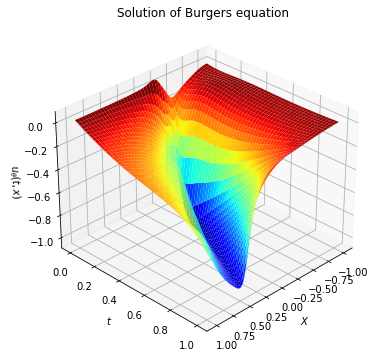

In [22]:
#from mpl_toolkit.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Set up meshgrid
N = 600
xspace = np.linspace(lb[0], ub[0], N+1)
tspace = np.linspace(lb[1], ub[1], N+1)
X, T = np.meshgrid(xspace, tspace)

Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Determine predicitons of u(x,t)
upred = model(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1, N+1)

# Surface plot of solution u(x, t)
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, T, U, cmap = 'jet')
ax.view_init(30, 45)
ax.set_xlabel('$X$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')

Text(0.5, 0.92, 'Solution of Burgers equation')

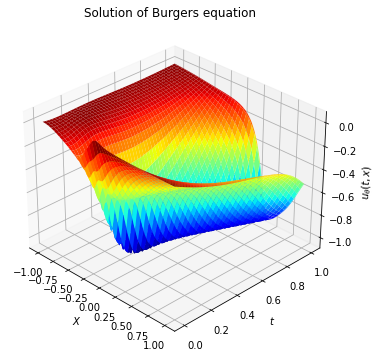

In [23]:
# Surface plot of solution u(x, t)
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, T, U, cmap = 'jet')
ax.view_init(30, -45)
ax.set_xlabel('$X$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')


### Plot the evolution of loss

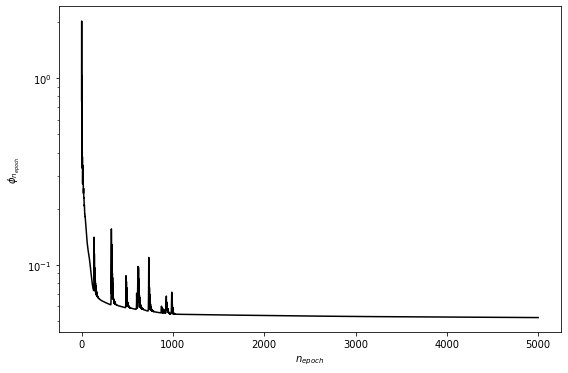

In [24]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');